In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import copy
import os
import time

cudnn.benchmark = True

In [3]:
# Constants
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SEED = 490

In [4]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [7]:
# Create datasets
image_dataset = datasets.ImageFolder(data_dir, transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

In [8]:
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 75000
    Root location: /kaggle/input/rice-image-dataset/Rice_Image_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [9]:
val_length = int(len(image_dataset) * VAL_SIZE)
test_length = int(len(image_dataset) * TEST_SIZE)
train_length = len(image_dataset) - (val_length + test_length)
train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_length, val_length, test_length])

In [10]:
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val', 'test'] }

In [11]:
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=x!='test', num_workers=2)
              for x in ['train', 'val', 'test'] }

In [12]:
class_names = image_datasets['train'].dataset.classes
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

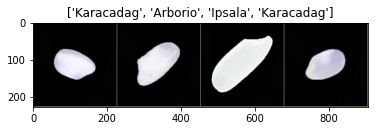

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs[:4])

# Display the images
imshow(out, title=[class_names[x] for x in classes[:4]])

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - epoch_start
        print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
def get_test_accuracy(model):
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels.data)
    
    accuracy = correct.double() / dataset_sizes['test']
    
    print(f'Test accuracy: {accuracy:4f}')
    
    return accuracy

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# AlexNet with SGD

In [18]:
alexnet1 = torchvision.models.alexnet(pretrained=True)
for param in alexnet1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final layer (6) of AlexNet has 4096 input features, change number according to
# model architecture
alexnet1.classifier._modules['6'] = nn.Linear(4096, len(class_names))

alexnet1 = alexnet1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(alexnet1.classifier._modules['6'].parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [19]:
alexnet1, a1_train_loss, a1_val_loss, a1_train_acc, a1_val_acc = train_model(
    alexnet1, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 8.3418 Acc: 0.9080
val Loss: 5.9560 Acc: 0.9348
Epoch time: 5m 25s

Epoch 1/19
----------
train Loss: 7.8073 Acc: 0.9287
val Loss: 1.5860 Acc: 0.9793
Epoch time: 4m 8s

Epoch 2/19
----------
train Loss: 7.3546 Acc: 0.9335
val Loss: 8.6326 Acc: 0.9094
Epoch time: 4m 3s

Epoch 3/19
----------
train Loss: 7.4832 Acc: 0.9341
val Loss: 2.6959 Acc: 0.9724
Epoch time: 4m 4s

Epoch 4/19
----------
train Loss: 7.1194 Acc: 0.9374
val Loss: 1.9416 Acc: 0.9761
Epoch time: 4m 4s

Epoch 5/19
----------
train Loss: 7.2672 Acc: 0.9388
val Loss: 6.2381 Acc: 0.9338
Epoch time: 4m 2s

Epoch 6/19
----------
train Loss: 7.0911 Acc: 0.9399
val Loss: 1.6848 Acc: 0.9798
Epoch time: 4m 3s

Epoch 7/19
----------
train Loss: 3.8341 Acc: 0.9593
val Loss: 1.0380 Acc: 0.9834
Epoch time: 4m 2s

Epoch 8/19
----------
train Loss: 3.5859 Acc: 0.9586
val Loss: 0.9877 Acc: 0.9840
Epoch time: 4m 3s

Epoch 9/19
----------
train Loss: 3.2898 Acc: 0.9581
val Loss: 0.7890 Acc: 0.9857
Epoch ti

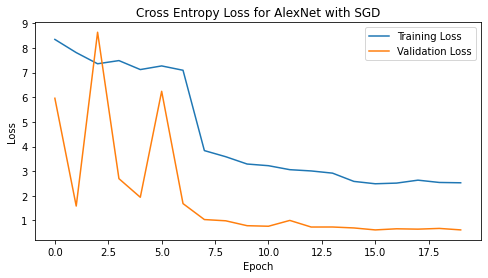

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(a1_train_loss, label='Training Loss')
plt.plot(a1_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for AlexNet with SGD')
plt.savefig('AlexNet SGD Loss.png')
plt.show()

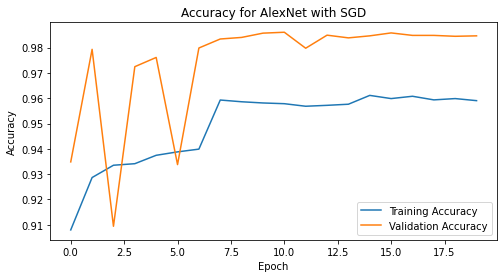

In [21]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in a1_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in a1_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for AlexNet with SGD')
plt.savefig('AlexNet SGD Accuracy.png')
plt.show()

In [22]:
torch.save(alexnet1.state_dict(), 'alexnet1.pth')

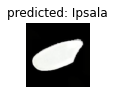

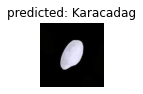

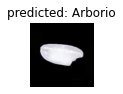

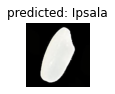

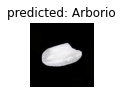

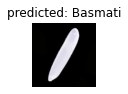

In [23]:
visualize_model(alexnet1)

plt.show()

In [24]:
a1_test_accuracy = get_test_accuracy(alexnet1)

Test accuracy: 0.985156


# AlexNet with Adadelta

In [25]:
alexnet2 = torchvision.models.alexnet(pretrained=True)
for param in alexnet2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final layer (6) of AlexNet has 4096 input features, change number according to
# model architecture
alexnet2.classifier._modules['6'] = nn.Linear(4096, len(class_names))

alexnet2 = alexnet2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adadelta(alexnet2.classifier._modules['6'].parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
alexnet2, a2_train_loss, a2_val_loss, a2_train_acc, a2_val_acc = train_model(
    alexnet2, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2981 Acc: 0.9090
val Loss: 0.1156 Acc: 0.9685
Epoch time: 4m 4s

Epoch 1/19
----------
train Loss: 0.1656 Acc: 0.9413
val Loss: 0.0888 Acc: 0.9735
Epoch time: 4m 4s

Epoch 2/19
----------
train Loss: 0.1538 Acc: 0.9429
val Loss: 0.0787 Acc: 0.9750
Epoch time: 4m 3s

Epoch 3/19
----------
train Loss: 0.1430 Acc: 0.9490
val Loss: 0.0721 Acc: 0.9769
Epoch time: 4m 4s

Epoch 4/19
----------
train Loss: 0.1425 Acc: 0.9476
val Loss: 0.0683 Acc: 0.9781
Epoch time: 4m 4s

Epoch 5/19
----------
train Loss: 0.1380 Acc: 0.9488
val Loss: 0.0659 Acc: 0.9789
Epoch time: 4m 4s

Epoch 6/19
----------
train Loss: 0.1364 Acc: 0.9508
val Loss: 0.0654 Acc: 0.9769
Epoch time: 4m 2s

Epoch 7/19
----------
train Loss: 0.1349 Acc: 0.9505
val Loss: 0.0645 Acc: 0.9782
Epoch time: 4m 3s

Epoch 8/19
----------
train Loss: 0.1354 Acc: 0.9503
val Loss: 0.0644 Acc: 0.9780
Epoch time: 4m 4s

Epoch 9/19
----------
train Loss: 0.1333 Acc: 0.9517
val Loss: 0.0639 Acc: 0.9783
Epoch tim

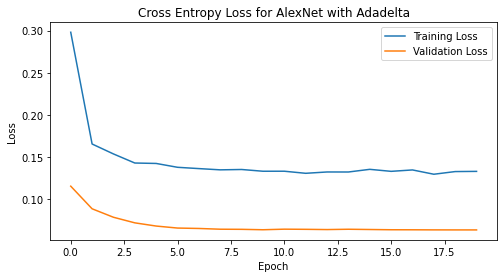

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(a2_train_loss, label='Training Loss')
plt.plot(a2_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for AlexNet with Adadelta')
plt.savefig('AlexNet Adadelta Loss.png')
plt.show()

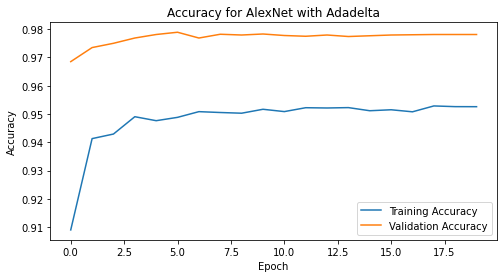

In [28]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in a2_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in a2_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for AlexNet with Adadelta')
plt.savefig('AlexNet Adadelta Accuracy.png')
plt.show()

In [29]:
torch.save(alexnet2.state_dict(), 'alexnet2.pth')

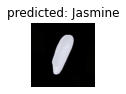

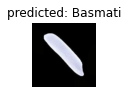

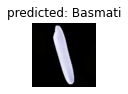

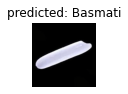

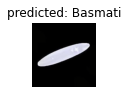

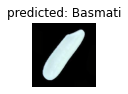

In [30]:
visualize_model(alexnet2)

plt.show()

In [31]:
a2_test_accuracy = get_test_accuracy(alexnet2)

Test accuracy: 0.979200


# AlexNet with RMSprop

In [32]:
alexnet3 = torchvision.models.alexnet(pretrained=True)
for param in alexnet3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final layer (6) of AlexNet has 4096 input features, change number according to
# model architecture
alexnet3.classifier._modules['6'] = nn.Linear(4096, len(class_names))

alexnet3 = alexnet3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.RMSprop(alexnet3.classifier._modules['6'].parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
alexnet3, a3_train_loss, a3_val_loss, a3_train_acc, a3_val_acc = train_model(
    alexnet3, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 21.3738 Acc: 0.9148
val Loss: 4.6517 Acc: 0.9780
Epoch time: 4m 3s

Epoch 1/19
----------
train Loss: 21.9548 Acc: 0.9346
val Loss: 4.7007 Acc: 0.9797
Epoch time: 4m 2s

Epoch 2/19
----------
train Loss: 22.8986 Acc: 0.9377
val Loss: 5.6706 Acc: 0.9799
Epoch time: 4m 2s

Epoch 3/19
----------
train Loss: 23.5176 Acc: 0.9387
val Loss: 6.1818 Acc: 0.9780
Epoch time: 4m 1s

Epoch 4/19
----------
train Loss: 23.9247 Acc: 0.9401
val Loss: 14.9810 Acc: 0.9543
Epoch time: 4m 2s

Epoch 5/19
----------
train Loss: 23.6945 Acc: 0.9422
val Loss: 14.9118 Acc: 0.9516
Epoch time: 4m 4s

Epoch 6/19
----------
train Loss: 23.5973 Acc: 0.9436
val Loss: 8.5928 Acc: 0.9734
Epoch time: 4m 4s

Epoch 7/19
----------
train Loss: 15.8301 Acc: 0.9575
val Loss: 4.8422 Acc: 0.9782
Epoch time: 4m 2s

Epoch 8/19
----------
train Loss: 13.7720 Acc: 0.9591
val Loss: 4.0275 Acc: 0.9804
Epoch time: 4m 2s

Epoch 9/19
----------
train Loss: 13.2580 Acc: 0.9583
val Loss: 3.2979 Acc: 0.98

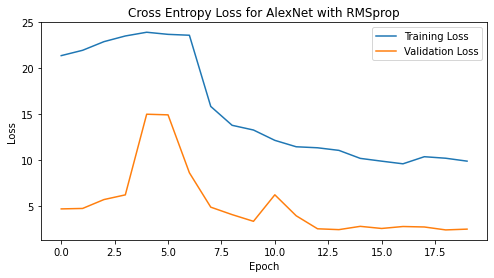

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(a3_train_loss, label='Training Loss')
plt.plot(a3_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for AlexNet with RMSprop')
plt.savefig('AlexNet RMSprop Loss.png')
plt.show()

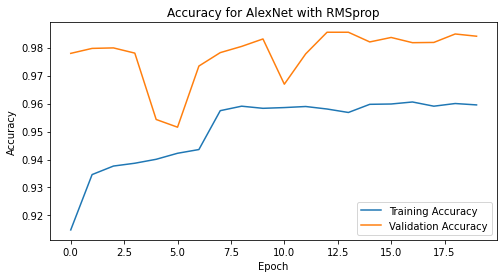

In [35]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in a3_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in a3_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for AlexNet with RMSprop')
plt.savefig('AlexNet RMSprop Accuracy.png')
plt.show()

In [36]:
torch.save(alexnet3.state_dict(), 'alexnet3.pth')

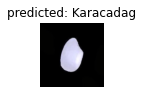

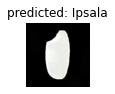

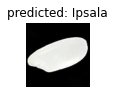

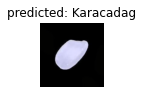

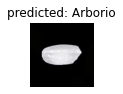

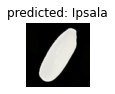

In [37]:
visualize_model(alexnet3)

plt.show()

In [38]:
a3_test_accuracy = get_test_accuracy(alexnet3)

Test accuracy: 0.985600
